In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3070 Laptop GPU (UUID: GPU-575329a1-fcef-e88c-e45c-de57a5e0921d)


In [2]:
import torch
print(torch.__version__)


2.2.2


In [3]:
import torch

# Kiểm tra xem CUDA có khả dụng hay không
cuda_available = torch.cuda.is_available()

print("CUDA is available:", cuda_available)

# Nếu CUDA khả dụng, kiểm tra tên của GPU
if cuda_available:
    print("Device name:", torch.cuda.get_device_name(0))


CUDA is available: True
Device name: NVIDIA GeForce RTX 3070 Laptop GPU


#Sahil's space

## Imports and data

In [4]:
!pip install segmentation-models-pytorch

In [5]:
################# IMPORT PACKAGES #############
%load_ext tensorboard
import os
import sys
import cv2
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
# from google.colab.patches import cv2_imshow
import sklearn
from sklearn import model_selection
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import copy
import time

import segmentation_models_pytorch

import albumentations as A
#from albumentations.pytorch import ToTensorV2
from albumentations.pytorch import ToTensorV2

d:\Anaconda\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
os.makedirs("./Train/Labeled/Flooded/image", exist_ok=True)
os.makedirs("./Train/Labeled/Non-Flooded/image", exist_ok=True)
os.makedirs("./Train/Labeled/Flooded/mask", exist_ok=True)
os.makedirs("./Train/Labeled/Non-Flooded/mask", exist_ok=True)
os.makedirs("./Train/Unlabeled/image", exist_ok=True)
os.makedirs("./test/image", exist_ok=True)

In [7]:
RESIZE=(512,512)
temp_root = "./"
local_root = "./"
def resize_and_save(path, resize=RESIZE, samples='all'):
  if len(os.listdir(os.path.join(local_root, path))) == 0:
    print(f"{path} --> Saving...\n")
    if samples == 'all':
      samples = len(os.listdir(os.path.join(temp_root, path)))
    for img_name in tqdm(os.listdir(os.path.join(temp_root, path))[:samples]):
      img = cv2.imread(os.path.join(temp_root, path, img_name))
      img = cv2.resize(img, RESIZE)
      cv2.imwrite(os.path.join(local_root, path, img_name), img)
  else:
    print(f"{path} --> images are already saved")

In [8]:
resize_and_save("./Train/Labeled/Flooded/image/")
resize_and_save("./Train/Labeled/Non-Flooded/image/")
resize_and_save("./Train/Labeled/Flooded/mask/")
resize_and_save("./Train/Labeled/Non-Flooded/mask/")
resize_and_save("./Train/Unlabeled/image/")
resize_and_save("./test/image/")
resize_and_save("./Train/Unlabeled/image/", samples=100)

./Train/Labeled/Flooded/image/ --> images are already saved
./Train/Labeled/Non-Flooded/image/ --> images are already saved
./Train/Labeled/Flooded/mask/ --> images are already saved
./Train/Labeled/Non-Flooded/mask/ --> images are already saved
./Train/Unlabeled/image/ --> images are already saved
./test/image/ --> images are already saved
./Train/Unlabeled/image/ --> images are already saved


In [9]:
import os
from PIL import Image

# Directory containing images
img_dir = './Train/Labeled/Flooded/image/'

# List all files in the directory
imgs = os.listdir(img_dir)

for i in imgs:
    # Construct full file path
    img_path = os.path.join(img_dir, i)

    # Open image
    with Image.open(img_path) as img:
        # Print image size
        print(img.size)
        # Break after the first image
        break


(512, 512)


In [10]:
local_root = './'  # This remains consistent with forward slashes
flood_dir = "Train/Labeled/Flooded"
non_flood_dir = "Train/Labeled/Non-Flooded"

f_img_dir = os.path.join(local_root, flood_dir, "image").replace('\\', '/')
f_mask_dir = os.path.join(local_root, flood_dir, "mask").replace('\\', '/')
n_img_dir = os.path.join(local_root, non_flood_dir, "image").replace('\\', '/')
n_mask_dir = os.path.join(local_root, non_flood_dir, "mask").replace('\\', '/')

# Count images and masks
f_img = len(os.listdir(f_img_dir))
f_mask = len(os.listdir(f_mask_dir))
n_img = len(os.listdir(n_img_dir))
n_mask = len(os.listdir(n_mask_dir))
print(f"Flooded images:      {f_img} Flooded masks:     {f_mask}")
print(f"Non-Flooded images: {n_img} Non-Flooded masks: {n_mask}")


Flooded images:      102 Flooded masks:     102
Non-Flooded images: 694 Non-Flooded masks: 694


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def cv2_imshow(title, image):
    """Display an image using matplotlib to mimic cv2.imshow."""
    if len(image.shape) == 3 and image.shape[2] == 3:  # Color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    else:  # Grayscale image
        plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [12]:
print("Flooded Image Directory:", f_img_dir)
print("Flooded Mask Directory:", f_mask_dir)
print("Non-Flooded Image Directory:", n_img_dir)
print("Non-Flooded Mask Directory:", n_mask_dir)


Flooded Image Directory: ./Train/Labeled/Flooded/image
Flooded Mask Directory: ./Train/Labeled/Flooded/mask
Non-Flooded Image Directory: ./Train/Labeled/Non-Flooded/image
Non-Flooded Mask Directory: ./Train/Labeled/Non-Flooded/mask


In [13]:
print("Files in Flooded Image Directory:", os.listdir(f_img_dir))
print("Files in Flooded Mask Directory:", os.listdir(f_mask_dir))
print("Files in Non-Flooded Image Directory:", os.listdir(n_img_dir))
print("Files in Non-Flooded Mask Directory:", os.listdir(n_mask_dir))


Files in Flooded Image Directory: ['10165.jpg', '10166.jpg', '10167.jpg', '10168.jpg', '10169.jpg', '10170.jpg', '10171.jpg', '10172.jpg', '10173.jpg', '10174.jpg', '10175.jpg', '10176.jpg', '10177.jpg', '10178.jpg', '10179.jpg', '10180.jpg', '10181.jpg', '10182.jpg', '10183.jpg', '10184.jpg', '10185.jpg', '10186.jpg', '10187.jpg', '10188.jpg', '10189.jpg', '10190.jpg', '10191.jpg', '10192.jpg', '10193.jpg', '10194.jpg', '10195.jpg', '10196.jpg', '10197.jpg', '10198.jpg', '10199.jpg', '10200.jpg', '10201.jpg', '10202.jpg', '10203.jpg', '10204.jpg', '10205.jpg', '10206.jpg', '10207.jpg', '10208.jpg', '10209.jpg', '10210.jpg', '10211.jpg', '10212.jpg', '10213.jpg', '10214.jpg', '10215.jpg', '10216.jpg', '10217.jpg', '6279.jpg', '6614.jpg', '6615.jpg', '6618.jpg', '6703.jpg', '6704.jpg', '6706.jpg', '6707.jpg', '6716.jpg', '7199.jpg', '7202.jpg', '7240.jpg', '7243.jpg', '7261.jpg', '7266.jpg', '7267.jpg', '7273.jpg', '7289.jpg', '7298.jpg', '7317.jpg', '7321.jpg', '7325.jpg', '7330.jpg', 

In [14]:
CLASSES={'Background':0,'Building-flooded':1,'Building-non-flooded':2,'Road-flooded':3,'Road-non-flooded':4,
         'Water':5,'Tree':6,'Vehicle':7,'Pool':8,'Grass':9}
IMG_DIM= 512

In [15]:
# CONFIG
TENSORBOARD_DIR = "./runs/"
MODEL_DIR = "./models/"
UNLABELLED_SPLIT = 100 # first 100 unlabelled examples will be used
## RAM storage error
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

#### UNET CONFIG #########
# ENCODER_DEPTH=5
# DECODER_CHANNELS=(256, 128, 64, 32, 16)
# # BATCH_SIZE= [8, 16, 32, 64, 128]
# # LR = [1, 1e-2, 1e-4, 1e-6]
# BATCH_SIZE = [8]
# LR = [1e-2]
# EPOCHS= 50
# ENCODER_NAME= 'resnet34'

# ####### DEEPLAB V3+ CONFIG #######
ENCODER_DEPTH=5
DECODER_CHANNELS=256
BATCH_SIZE= [8]
EPOCHS= 50
LR = [1e-3]
ENCODER_NAME= 'resnet50'

##Dataloader

In [16]:
dirs = """
flood_dir
non_flood_dir

f_img_dir
f_mask_dir
n_img_dir
n_mask_dir
"""
x_f = [os.path.join(f_img_dir, file) for file in sorted(os.listdir(f_img_dir))]
x_n = [os.path.join(n_img_dir, file) for file in sorted(os.listdir(n_img_dir))]

x = x_f + x_n

x_train, x_test = model_selection.train_test_split(x, test_size=0.3, shuffle=True)

train_transform1 = A.Compose([
        A.Resize(IMG_DIM, IMG_DIM),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        # A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

    ])

train_transform2=A.Compose([ToTensorV2()])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

##Train setup

###Functions

In [17]:
def dice_loss(pred, target, smooth = 1e-5):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

In [18]:
def calc_loss(pred, target, metrics, bce_weight=0.5, unlabelled=False):
    bce = F.binary_cross_entropy_with_logits(pred, target.to(torch.float32))
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    target_np=target.data.cpu().numpy()
    pred_np=pred.data.cpu().numpy()
    MIoU= np.mean(sklearn.metrics.jaccard_score(np.argmax(target_np,axis=1).flatten(), np.argmax(pred_np,axis=1).flatten(), average=None))
    loss = bce * bce_weight + dice * (1 - bce_weight)
    if not unlabelled:
      metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
      metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
      metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
      metrics['MIoU'] += MIoU * target.size(0)

    return loss

In [19]:
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

### Train function

In [20]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset

class SegDataset(Dataset):
    def __init__(self, x_paths, trans1, trans2, img_dim, unlabelled=False):
        self.x_paths = x_paths
        self.unlabelled = unlabelled
        if not self.unlabelled:
            self.y_paths = [x.replace("image", "mask").replace(".jpg", "_lab.png") for x in self.x_paths]
        else:
            self.y_paths = None
        self.img_dim = img_dim
        self.trans1 = trans1
        self.trans2 = trans2

    def __len__(self):
        return len(self.x_paths)

    def get_newMask(self, mask, classes, dim=(512, 512)):
        mask = torch.as_tensor(mask[:, :, 0], dtype=torch.int64)
        return torch.moveaxis(torch.nn.functional.one_hot(mask, num_classes=len(classes)), -1, 0)

    def __getitem__(self, index):
        image = cv2.imread(self.x_paths[index])
        if image is None:
            raise ValueError(f"Failed to load image at index {index} from path {self.x_paths[index]}")

        kernel = np.ones((2, 2), np.uint8)
        image = cv2.bilateralFilter(image, 5, 75, 75)
        image = cv2.erode(cv2.dilate(image, kernel, iterations=2), kernel, iterations=1)

        if not self.unlabelled:
            mask = cv2.imread(self.y_paths[index])
            if mask is None:
                raise ValueError(f"Failed to load mask at index {index} from path {self.y_paths[index]}")
        else:
            mask = np.random.rand(512, 512, 3).astype(np.uint8)  # Ensure it's a numpy array

        if self.trans1:
            transformed1 = self.trans1(image=image, mask=mask)
            image = transformed1["image"]
            mask = transformed1["mask"]
            mask = mask if isinstance(mask, np.ndarray) else np.array(mask)  # Ensure mask is numpy array
            mask = self.get_newMask(mask, classes=CLASSES, dim=self.img_dim)

        if self.trans2:
            transformed2 = self.trans2(image=image)
            image = transformed2["image"]

        return image, mask


In [21]:
training_set = SegDataset(x_train,  train_transform1, train_transform2, img_dim=IMG_DIM)
testing_set = SegDataset(x_test, train_transform1,train_transform2, img_dim=IMG_DIM)
image_datasets = {'train': training_set, 'valid': testing_set}

In [22]:
a, b = training_set[0]

In [23]:

u_dir = "./Train/Unlabeled/image/"
unlabelled_paths = [os.path.join(u_dir, file) for file in os.listdir(u_dir)]
unlabelled_set = SegDataset(unlabelled_paths[0:-500], trans1=train_transform1,trans2=train_transform2, img_dim=IMG_DIM, unlabelled=True)
image_datasets["unlabelled"] = unlabelled_set

In [24]:
def train_model(unique_name, num_epochs=EPOCHS, start_alpha_from=15, reach_max_alpha_in=655, max_alpha=0.5):
  for lr in LR:
    for bs in BATCH_SIZE:
      # if(lr == 1 and (bs == 8 or bs == 16)):
      #   continue
      print("__"*80)
      print("__"*80)
      print(f"name: {unique_name} LR: {lr} BS: {bs}")
      print("__"*80)
      print("__"*80)

      alphas = np.linspace(0, max_alpha, reach_max_alpha_in-start_alpha_from)

      os.makedirs(os.path.join(TENSORBOARD_DIR, f'{unique_name}-{lr}-{bs}'), exist_ok=True)
      writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_DIR, f'{unique_name}-{lr}-{bs}'))

      best_loss = 1e10
      best_epoch = 0
      best_miou = 0

      train_data_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, num_workers=0)
      test_data_loader = torch.utils.data.DataLoader(testing_set, batch_size=bs, num_workers=0)
      ulbl_data_loader = torch.utils.data.DataLoader(unlabelled_set, batch_size=bs, num_workers=0)
      dataloaders = {'train': train_data_loader,'valid': test_data_loader, "unlabelled" : ulbl_data_loader}

      # model = segmentation_models_pytorch.Unet(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
      #                                     decoder_channels=DECODER_CHANNELS, classes=len(CLASSES))
      model = segmentation_models_pytorch.DeepLabV3Plus(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
                                          decoder_channels=DECODER_CHANNELS, classes=len(CLASSES))
      model = model.to(device)
      model.load_state_dict(torch.load("./models/abhi_sudo_full_2-pretrained_preproc_1-deeplabv3+-ep_0-0.001-8.pt",map_location=torch.device('cuda')))
      best_model_wts = copy.deepcopy(model.state_dict())

      # optimizer = optim.Adam(model.parameters(), lr=lr) ## IF YOU CHANGE THIS, CHANGE THE UNIQUE ABOVE
      optimizer = optim.SGD(model.parameters(), lr=0.01)
      # scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[7, 20, 80], gamma=0.1)
      scheduler = None

      for epoch in range(num_epochs):
          print('__' * 80)
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('__' * 80)

          if epoch < start_alpha_from:
            alpha = 0
          elif epoch-start_alpha_from >= len(alphas):
            alpha = alphas[-1]
          else:
            alpha = alphas[max(0,epoch-start_alpha_from)]

          since = time.time()

          for phase in ['train', 'unlabelled', 'valid']:
              print(phase)
              print("__"*20)
              if alpha == 0 and phase == 'unlabelled':
                continue
              if phase in ['train', 'unlabelled']:
                model.train()
              else:
                model.eval()

              metrics = defaultdict(float)
              epoch_samples = 0

              for batch_no, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                  inputs = inputs.to(device)
                  if phase in ['train', 'valid']:
                    labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  with torch.set_grad_enabled(phase in ['train', 'unlabelled']):
                      outputs = model(inputs)
                      # loss = calc_loss(outputs, labels, metrics)

                      if phase in ["train", "valid"]:
                        loss = calc_loss(outputs, labels, metrics)
                      else:
                        loss = alpha * calc_loss(outputs, pseudo_labels[batch_no].to(device), metrics, unlabelled=True)
                      # backward + optimize only if in training phase
                      if phase in ['train', 'unlabelled']:
                          loss.backward()
                          optimizer.step()

                  # statistics
                  epoch_samples += inputs.size(0)

              if scheduler is not None and phase == "train":
                scheduler.step()

              print_metrics(metrics, epoch_samples, phase)
              epoch_loss = metrics['loss'] / epoch_samples
              epoch_miou = metrics['MIoU'] / epoch_samples

              ## tensorboard writer
              if phase == "train":
                writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
                writer.add_scalar(f'MIoU/{phase}', epoch_miou, epoch)
                writer.add_scalar(f'Alpha/{phase}', alpha, epoch)
                # writer.add_scalars(f'Loss/{phase}', {'loss':epoch_loss, 'alpha':alpha}, epoch)
                # writer.add_scalars(f'MIoU/{phase}', {'miou':epoch_miou, 'alpha':alpha}, epoch)

              if phase == "valid": # older implementation had phase == 'val'
                writer.add_scalar(f'Loss/val', epoch_loss, epoch)
                writer.add_scalar(f'MIoU/val', epoch_miou, epoch)
                writer.add_scalar(f'Alpha/val', alpha, epoch)
                # writer.add_scalars(f'Loss/val', {'loss':epoch_loss, 'alpha':alpha}, epoch)
                # writer.add_scalars(f'MIoU/val', {'miou':epoch_miou, 'alpha':alpha}, epoch)

              ## generate pseudo labels
              if phase == 'train' and epoch >= start_alpha_from-1:
                pseudo_labels = []
                model.eval()
                for inputs, _ in tqdm(dataloaders['unlabelled'], desc="Predicting pseudo labels"):
                  inputs = inputs.to(device)
                  with torch.no_grad():
                    outputs = model(inputs)
                    pseudo_labels.append(outputs.detach().cpu())

              # deep copy the model
              if phase == 'valid' and epoch_miou > best_miou:
                  best_miou = epoch_miou
                  best_epoch = epoch
                  best_model_wts = copy.deepcopy(model.state_dict())
                  print(f'Best miou: {best_miou:.4f} Epoch: {epoch}')

              if epoch % 5 == 0:
                  PATH = os.path.join(MODEL_DIR, f'{unique_name}-ep_{best_epoch}-{lr}-{bs}.pt')
                  torch.save(best_model_wts, PATH)
                  PATH = os.path.join(MODEL_DIR, f'{unique_name}-ep_{epoch}-{lr}-{bs}.pt')
                  torch.save(model.state_dict(), PATH)

          time_elapsed = time.time() - since
          print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

      print('Best val loss: {:4f}'.format(best_loss))
      writer.close()
      # load best model weights
      # model.load_state_dict(best_model_wts)
      PATH = os.path.join(MODEL_DIR, f'{unique_name}-ep_{best_epoch}-{lr}-{bs}.pt')
      torch.save(best_model_wts, PATH)

  return model

##Training

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
os.chdir("./")

cuda:0


In [26]:
torch.cuda.empty_cache()

In [27]:
unique_name = "abhi_sudo_full_2-pretrained_preproc_1-deeplabv3+"

In [28]:
model = train_model(unique_name, num_epochs=15)

________________________________________________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________________________________________________
name: abhi_sudo_full_2-pretrained_preproc_1-deeplabv3+ LR: 0.001 BS: 8
________________________________________________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________________________________________________
Epoch 0/14
_________________________________________________________________________________________________________________

100%|██████████| 70/70 [01:08<00:00,  1.02it/s]


train: bce: 0.064411, dice: 0.751937, loss: 0.408174, MIoU: 0.463280
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


valid: bce: 0.047782, dice: 0.737291, loss: 0.392536, MIoU: 0.520813
Best miou: 0.5208 Epoch: 0
1m 37s
________________________________________________________________________________________________________________________________________________________________
Epoch 1/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:05<00:00,  1.07it/s]


train: bce: 0.061660, dice: 0.748544, loss: 0.405102, MIoU: 0.467215
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


valid: bce: 0.051980, dice: 0.739328, loss: 0.395654, MIoU: 0.510899
1m 33s
________________________________________________________________________________________________________________________________________________________________
Epoch 2/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:05<00:00,  1.08it/s]


train: bce: 0.061887, dice: 0.748931, loss: 0.405409, MIoU: 0.462551
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:27<00:00,  1.10it/s]


valid: bce: 0.048411, dice: 0.736761, loss: 0.392586, MIoU: 0.523832
Best miou: 0.5238 Epoch: 2
1m 32s
________________________________________________________________________________________________________________________________________________________________
Epoch 3/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:04<00:00,  1.09it/s]


train: bce: 0.061848, dice: 0.748708, loss: 0.405278, MIoU: 0.459704
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


valid: bce: 0.045904, dice: 0.736169, loss: 0.391037, MIoU: 0.527289
Best miou: 0.5273 Epoch: 3
1m 33s
________________________________________________________________________________________________________________________________________________________________
Epoch 4/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:06<00:00,  1.05it/s]


train: bce: 0.060806, dice: 0.748264, loss: 0.404535, MIoU: 0.468778
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


valid: bce: 0.046311, dice: 0.735142, loss: 0.390726, MIoU: 0.523257
1m 33s
________________________________________________________________________________________________________________________________________________________________
Epoch 5/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:04<00:00,  1.09it/s]


train: bce: 0.062221, dice: 0.749406, loss: 0.405814, MIoU: 0.466398
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:27<00:00,  1.11it/s]


valid: bce: 0.045787, dice: 0.733182, loss: 0.389484, MIoU: 0.532595
Best miou: 0.5326 Epoch: 5
1m 32s
________________________________________________________________________________________________________________________________________________________________
Epoch 6/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:03<00:00,  1.10it/s]


train: bce: 0.060791, dice: 0.748342, loss: 0.404566, MIoU: 0.466090
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


valid: bce: 0.047140, dice: 0.735541, loss: 0.391340, MIoU: 0.515345
1m 31s
________________________________________________________________________________________________________________________________________________________________
Epoch 7/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:04<00:00,  1.09it/s]


train: bce: 0.062029, dice: 0.749969, loss: 0.405999, MIoU: 0.464374
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


valid: bce: 0.045904, dice: 0.734589, loss: 0.390246, MIoU: 0.517007
1m 31s
________________________________________________________________________________________________________________________________________________________________
Epoch 8/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:03<00:00,  1.10it/s]


train: bce: 0.060854, dice: 0.750238, loss: 0.405546, MIoU: 0.463817
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:26<00:00,  1.11it/s]


valid: bce: 0.046294, dice: 0.735074, loss: 0.390684, MIoU: 0.521374
1m 31s
________________________________________________________________________________________________________________________________________________________________
Epoch 9/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:03<00:00,  1.10it/s]


train: bce: 0.061782, dice: 0.748962, loss: 0.405372, MIoU: 0.466415
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


valid: bce: 0.046457, dice: 0.738022, loss: 0.392240, MIoU: 0.512214
1m 31s
________________________________________________________________________________________________________________________________________________________________
Epoch 10/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:06<00:00,  1.05it/s]


train: bce: 0.060672, dice: 0.747989, loss: 0.404331, MIoU: 0.464266
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


valid: bce: 0.046034, dice: 0.735563, loss: 0.390799, MIoU: 0.531172
1m 37s
________________________________________________________________________________________________________________________________________________________________
Epoch 11/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:08<00:00,  1.02it/s]


train: bce: 0.059567, dice: 0.749159, loss: 0.404363, MIoU: 0.477205
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:27<00:00,  1.11it/s]


valid: bce: 0.052500, dice: 0.739613, loss: 0.396056, MIoU: 0.518245
1m 35s
________________________________________________________________________________________________________________________________________________________________
Epoch 12/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:07<00:00,  1.03it/s]


train: bce: 0.060497, dice: 0.747195, loss: 0.403846, MIoU: 0.469608
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


valid: bce: 0.048013, dice: 0.738059, loss: 0.393036, MIoU: 0.517560
1m 38s
________________________________________________________________________________________________________________________________________________________________
Epoch 13/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:13<00:00,  1.06s/it]


train: bce: 0.061348, dice: 0.748561, loss: 0.404955, MIoU: 0.471543
unlabelled
________________________________________
valid
________________________________________


100%|██████████| 30/30 [00:31<00:00,  1.06s/it]


valid: bce: 0.046672, dice: 0.735338, loss: 0.391005, MIoU: 0.513175
1m 46s
________________________________________________________________________________________________________________________________________________________________
Epoch 14/14
________________________________________________________________________________________________________________________________________________________________
train
________________________________________


100%|██████████| 70/70 [01:11<00:00,  1.02s/it]


train: bce: 0.059770, dice: 0.747580, loss: 0.403675, MIoU: 0.473163


Predicting pseudo labels: 100%|██████████| 200/200 [01:22<00:00,  2.44it/s]


unlabelled
________________________________________
valid
________________________________________


  7%|▋         | 2/30 [00:04<00:57,  2.06s/it]


KeyboardInterrupt: 

In [ ]:
# %ls ./models/

In [ ]:
model

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

#Saving Masks

##Config

In [42]:
MODEL_LOAD_PATH = f'./models/abhi_sudo_full_2-pretrained_preproc_1-deeplabv3+-ep_0-0.001-8.pt'
DIR_PATH = f'./test/image'
SAVE_PATH = f'./predictions'

os.makedirs(SAVE_PATH, exist_ok=True)

LOAD_SIZE = 8 # pred generating load size

##Code

In [43]:
# model = segmentation_models_pytorch.Unet(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
#                                           decoder_channels=DECODER_CHANNELS, classes=len(CLASSES))

model = segmentation_models_pytorch.DeepLabV3Plus(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
                                          decoder_channels=DECODER_CHANNELS, classes=len(CLASSES))
model = model.to(device)
model.load_state_dict(torch.load(MODEL_LOAD_PATH,map_location=torch.device('cuda')))
# model.eval()

<All keys matched successfully>

In [44]:
all_images=sorted(os.listdir(DIR_PATH))
all_masks=[x.replace(".jpg", ".png") for x in all_images]

image_paths=[os.path.join(DIR_PATH, file) for file in sorted(os.listdir(DIR_PATH))]
mask_paths=[os.path.join(SAVE_PATH, file) for file in all_masks]
print(len(image_paths))
print(mask_paths)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

448
['./predictions\\10163.png', './predictions\\10164.png', './predictions\\10167.png', './predictions\\10174.png', './predictions\\10183.png', './predictions\\10808.png', './predictions\\10812.png', './predictions\\10813.png', './predictions\\10814.png', './predictions\\10823.png', './predictions\\10829.png', './predictions\\10838.png', './predictions\\10839.png', './predictions\\10843.png', './predictions\\11483.png', './predictions\\6336.png', './predictions\\6342.png', './predictions\\6353.png', './predictions\\6362.png', './predictions\\6371.png', './predictions\\6377.png', './predictions\\6383.png', './predictions\\6389.png', './predictions\\6391.png', './predictions\\6394.png', './predictions\\6405.png', './predictions\\6412.png', './predictions\\6417.png', './predictions\\6419.png', './predictions\\6420.png', './predictions\\6445.png', './predictions\\6449.png', './predictions\\6452.png', './predictions\\6467.png', './predictions\\6468.png', './predictions\\6476.png', './predi

In [45]:
def reverse_transform_mask(inp):
    inp=inp.transpose((1, 2, 0))
    t_mask=np.argmax(inp,axis=2).astype('float32')
    t_mask=cv2.resize(t_mask, dsize=(4000, 3000))
    kernel = np.ones((3,3),np.uint8)
    t_mask = cv2.erode(t_mask, kernel, iterations=1)
    return t_mask

In [46]:
class ValDataset:
    def __init__(self, img_paths, val_trans, img_dim):
        self.img_paths = img_paths
        self.img_dim = img_dim
        self.val_trans=val_trans

    def __len__(self):
      return len(self.img_paths)

    def __getitem__(self, index):
      image = cv2.resize(cv2.imread(self.img_paths[index]), dsize=(self.img_dim, self.img_dim))

      kernel = np.ones((2,2),np.uint8)
      image = cv2.bilateralFilter(image, 5, 75, 75)
      image = cv2.erode(cv2.dilate(image, kernel, iterations=2), kernel, iterations=1)

      if self.val_trans:
        image=self.val_trans(image)
      return image, index

In [47]:
val_set = ValDataset(image_paths, val_transform , img_dim=IMG_DIM)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=LOAD_SIZE, shuffle=False)

In [48]:
torch.cuda.empty_cache()

In [49]:
model.eval()

for inputs, index in tqdm(val_dataloader):
  inputs = inputs.to("cuda")
  with torch.no_grad():
    preds = model(inputs)
    preds = F.sigmoid(preds)
    preds = preds.data.cpu().numpy()
  for i in range(LOAD_SIZE):
    f_mask=reverse_transform_mask(preds[i])
    cv2.imwrite(mask_paths[index[i]],f_mask)

100%|██████████| 56/56 [00:41<00:00,  1.35it/s]


In [50]:
# !zip -r sudo_full-pretrained_preproc_2_20.zip predictions
# !cp sudo_full-pretrained_preproc_2_20.zip /content/drive/MyDrive/512_Images

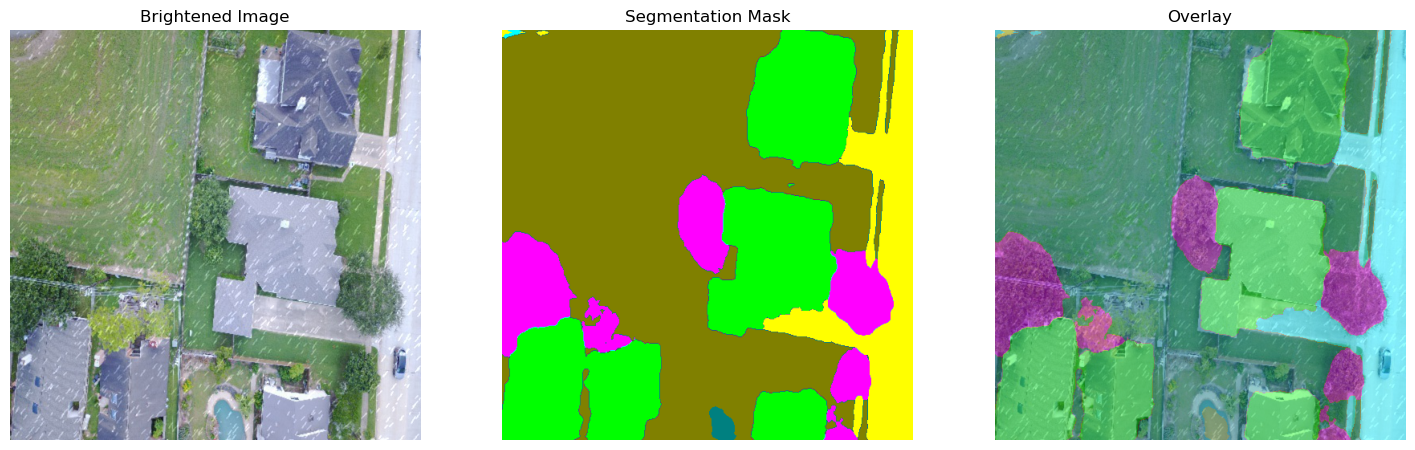

In [51]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define the color map for each class (adjust colors as necessary)
COLORS = {
    0: [0, 0, 0],          # Black: Background
    1: [255, 0, 0],        # Red: Building-flooded
    2: [0, 255, 0],        # Green: Building-non-flooded
    3: [0, 0, 255],        # Blue: Road-flooded
    4: [255, 255, 0],      # Yellow: Road-non-flooded
    5: [0, 255, 255],      # Cyan: Water
    6: [255, 0, 255],      # Magenta: Tree
    7: [128, 0, 128],      # Purple: Vehicle
    8: [0, 128, 128],      # Teal: Pool
    9: [128, 128, 0],      # Olive: Grass
}

# Read the predicted segmentation image
id = 6412## 6336
segmentation_result_path = f'predictions/{id}.png'
segmentation_result = cv2.imread(segmentation_result_path, cv2.IMREAD_GRAYSCALE)

# Check if the segmentation result was loaded properly
if segmentation_result is None:
    raise FileNotFoundError(f"Segmentation result not found at {segmentation_result_path}")

# Create an RGB image from the grayscale mask
colored_mask = np.zeros((*segmentation_result.shape, 3), dtype=np.uint8)

# Apply colors to the mask
for class_id, color in COLORS.items():
    colored_mask[segmentation_result == class_id] = color

# Load the provided brightened image directly
bright_image_path = f'./test/image/{id}.jpg'  # Change this to your image path if different
bright_image = cv2.imread(bright_image_path)

# Check if the brightened image was loaded properly
if bright_image is None:
    raise FileNotFoundError(f"Brightened image not found at {bright_image_path}")

# Resize the colored mask to match the dimensions of the brightened image
colored_mask_resized = cv2.resize(colored_mask, (bright_image.shape[1], bright_image.shape[0]))

# Blend the brightened original image with the resized colored mask
alpha_blend = 0.6  # Transparency factor for blending
blended_image = cv2.addWeighted(bright_image, alpha_blend, colored_mask_resized, 1 - alpha_blend, 0)

# Display the images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Segmentation Mask')
plt.imshow(colored_mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


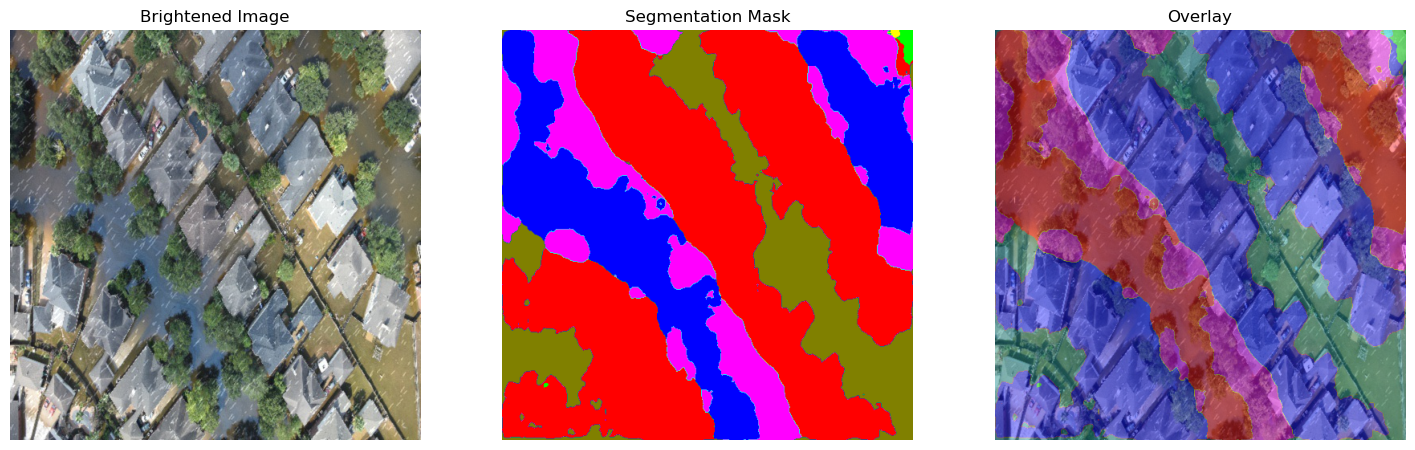

In [52]:

# Read the predicted segmentation image
id = 7423 ## 7253
segmentation_result_path = f'predictions/{id}.png'
segmentation_result = cv2.imread(segmentation_result_path, cv2.IMREAD_GRAYSCALE)

# Check if the segmentation result was loaded properly
if segmentation_result is None:
    raise FileNotFoundError(f"Segmentation result not found at {segmentation_result_path}")

# Create an RGB image from the grayscale mask
colored_mask = np.zeros((*segmentation_result.shape, 3), dtype=np.uint8)

# Apply colors to the mask
for class_id, color in COLORS.items():
    colored_mask[segmentation_result == class_id] = color

# Load the provided brightened image directly
bright_image_path = f'./test/image/{id}.jpg'  # Change this to your image path if different
bright_image = cv2.imread(bright_image_path)

# Check if the brightened image was loaded properly
if bright_image is None:
    raise FileNotFoundError(f"Brightened image not found at {bright_image_path}")

# Resize the colored mask to match the dimensions of the brightened image
colored_mask_resized = cv2.resize(colored_mask, (bright_image.shape[1], bright_image.shape[0]))

# Blend the brightened original image with the resized colored mask
alpha_blend = 0.6  # Transparency factor for blending
blended_image = cv2.addWeighted(bright_image, alpha_blend, colored_mask_resized, 1 - alpha_blend, 0)

# Display the images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Segmentation Mask')
plt.imshow(colored_mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


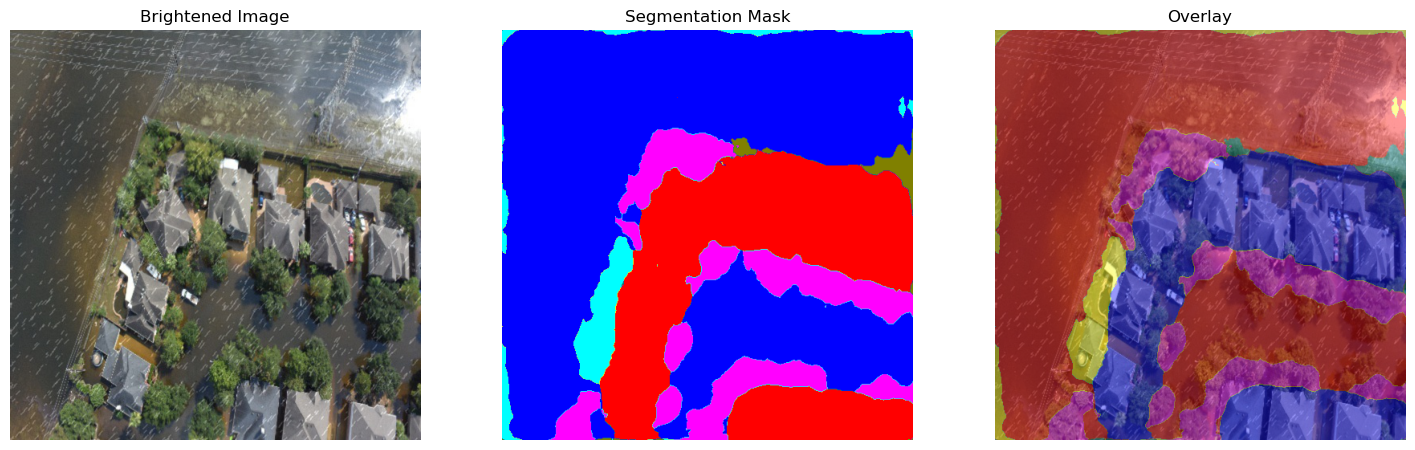

In [53]:

# Read the predicted segmentation image
id = 7333 ## 7253
segmentation_result_path = f'predictions/{id}.png'
segmentation_result = cv2.imread(segmentation_result_path, cv2.IMREAD_GRAYSCALE)

# Check if the segmentation result was loaded properly
if segmentation_result is None:
    raise FileNotFoundError(f"Segmentation result not found at {segmentation_result_path}")

# Create an RGB image from the grayscale mask
colored_mask = np.zeros((*segmentation_result.shape, 3), dtype=np.uint8)

# Apply colors to the mask
for class_id, color in COLORS.items():
    colored_mask[segmentation_result == class_id] = color

# Load the provided brightened image directly
bright_image_path = f'./test/image/{id}.jpg'  # Change this to your image path if different
bright_image = cv2.imread(bright_image_path)

# Check if the brightened image was loaded properly
if bright_image is None:
    raise FileNotFoundError(f"Brightened image not found at {bright_image_path}")

# Resize the colored mask to match the dimensions of the brightened image
colored_mask_resized = cv2.resize(colored_mask, (bright_image.shape[1], bright_image.shape[0]))

# Blend the brightened original image with the resized colored mask
alpha_blend = 0.6  # Transparency factor for blending
blended_image = cv2.addWeighted(bright_image, alpha_blend, colored_mask_resized, 1 - alpha_blend, 0)

# Display the images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Segmentation Mask')
plt.imshow(colored_mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


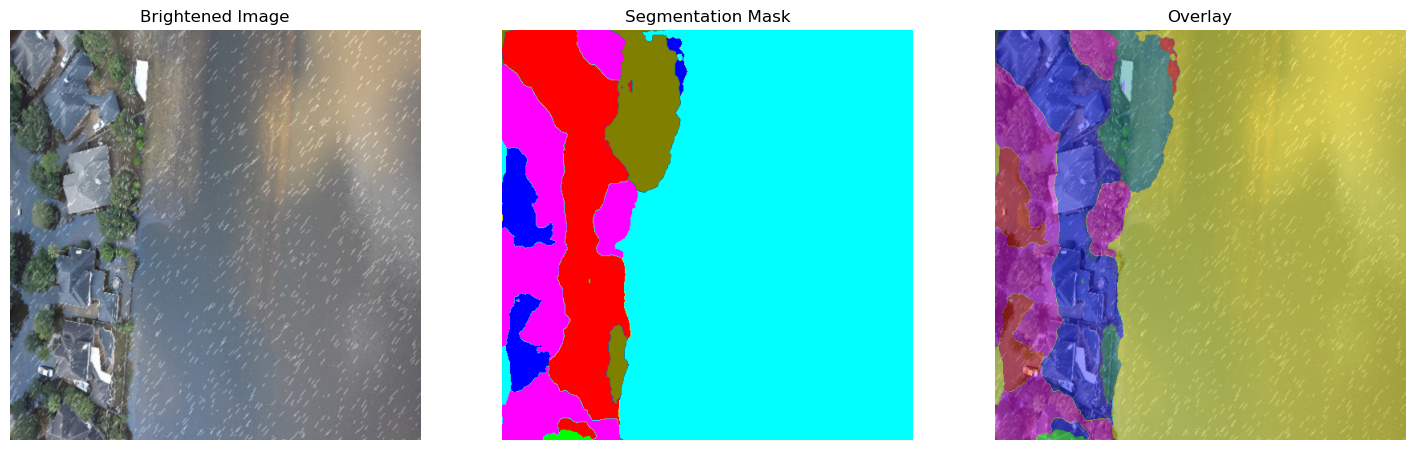

In [54]:

# Read the predicted segmentation image
id = 7457
segmentation_result_path = f'predictions/{id}.png'
segmentation_result = cv2.imread(segmentation_result_path, cv2.IMREAD_GRAYSCALE)

# Check if the segmentation result was loaded properly
if segmentation_result is None:
    raise FileNotFoundError(f"Segmentation result not found at {segmentation_result_path}")

# Create an RGB image from the grayscale mask
colored_mask = np.zeros((*segmentation_result.shape, 3), dtype=np.uint8)

# Apply colors to the mask
for class_id, color in COLORS.items():
    colored_mask[segmentation_result == class_id] = color

# Load the provided brightened image directly
bright_image_path = f'./test/image/{id}.jpg'  # Change this to your image path if different
bright_image = cv2.imread(bright_image_path)

# Check if the brightened image was loaded properly
if bright_image is None:
    raise FileNotFoundError(f"Brightened image not found at {bright_image_path}")

# Resize the colored mask to match the dimensions of the brightened image
colored_mask_resized = cv2.resize(colored_mask, (bright_image.shape[1], bright_image.shape[0]))

# Blend the brightened original image with the resized colored mask
alpha_blend = 0.6  # Transparency factor for blending
blended_image = cv2.addWeighted(bright_image, alpha_blend, colored_mask_resized, 1 - alpha_blend, 0)

# Display the images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Segmentation Mask')
plt.imshow(colored_mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()
